In [ ]:
ENV["PYTHON"]=""
using Pkg
Pkg.build("PyCall")
Pkg.add("BenchmarkTools")

In [1]:
using IMinuit
using BenchmarkTools

┌ Info: Precompiling IMinuit [beb75e20-2205-47e6-ad51-640e9c2309f1]
└ @ Base loading.jl:1278


In [2]:
f(x) = x[1]^2 + (x[2]-1)^2 + (x[3]-2)^4
f1(x, y, z) = x^2 + (y-1)^2 + (z-2)^4

f1 (generic function with 1 method)

In [3]:
# using array parameters
m = Minuit(f, [1, 1, 4], fix_x0 = true)
migrad(m)

PyObject MigradResult(fmin=FMin(fval=1.0000370129083695, edm=2.4670682282505703e-05, tolerance=0.1, nfcn=45, ncalls=45, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=1.0, error=0.01, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.0, error=0.9999999999400042, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.0779988685764814, error=5.233092083066116, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [4]:
# a new fit can continue from the previous fit
m_new = Minuit(f, m, fix_x0 = false)
migrad(m_new)

PyObject MigradResult(fmin=FMin(fval=7.285091391992251e-06, edm=4.854434939210982e-06, tolerance=0.1, nfcn=40, ncalls=40, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=-9.230505249036014e-11, error=0.9999999999999991, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.0, error=0.9999999999998908, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.0519527751467623, error=7.854497166409804, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [5]:
# using array parameters, using `ForwardDiff: gradient` to compute the gradient
gradf(x) = gradient(f, x)
mgrad = Minuit(f, [1, 1, 4], grad = gradf)
migrad(mgrad)

PyObject MigradResult(fmin=FMin(fval=0.00010058909436091441, edm=6.749340318344347e-05, tolerance=0.1, nfcn=69, ncalls=69, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=0.0011440753757503627, error=1.0000000000000058, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=1.0, error=0.9999999999999785, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=2.099819558675038, error=4.089726291666442, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [6]:
# parameters are given individually
m1 = Minuit(f1, x = 1, y = 1, z = 4)
migrad(m1)

PyObject MigradResult(fmin=FMin(fval=0.0001682888749907514, edm=0.00011476370188508502, tolerance=0.1, nfcn=89, ncalls=89, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x', value=0.002778199292675712, error=0.9999999999999966, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='y', value=1.0000000000000002, error=0.9999999999998966, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='z', value=2.112568383318672, error=3.626614534698427, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [7]:
@show iminuit.version.__version__
propertynames(m)

iminuit.version.__version__ = "1.4.9"


102-element Array{Symbol,1}:
 :LEAST_SQUARES
 :LIKELIHOOD
 :__class__
 :__delattr__
 :__dir__
 :__doc__
 :__eq__
 :__format__
 :__ge__
 :__getattribute__
 :__gt__
 :__hash__
 :__init__
 ⋮
 :profile
 :set_errordef
 :set_print_level
 :set_strategy
 :set_up
 :strategy
 :throw_nan
 :tol
 :use_array_call
 :valid
 :values
 :var2pos

In [8]:
# the doc strings are from `iminuit`
@doc migrad

Docstring pulled from the Python `iminuit`:

Minuit.migrad(self, ncall=None, resume=True, int nsplit=1, precision=None)
Run MIGRAD.

        MIGRAD is a robust minimisation algorithm which earned its reputation
        in 40+ years of almost exclusive usage in high-energy physics. How
        MIGRAD works is described in the `MINUIT paper`_.

        **Arguments:**

            * **ncall**: integer or None, optional; (approximate)
              maximum number of call before MIGRAD will stop trying. Default: None
              (indicates to use MIGRAD's internal heuristic). Using nsplit > 1
              requires ncall > 0. Note: MIGRAD may slightly violate this limit,
              because it checks the condition only after a full iteration of the
              algorithm, which usually performs several function calls.

            * **resume**: boolean indicating whether MIGRAD should resume from
              the previous minimiser attempt(True) or should start from the
              

## Example: Fit to the BES data of the π⁺π⁻ energy distribution of ψ'→J/ψπ⁺π⁻

The data are taken from [BES Collaboration, Phys. Rev. D 62 (2000) 032002](https://inspirehep.net/literature/507637).

Here we use a simple model, which is not meant to be the correct one, to fit to the data.

In [ ]:
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("PyPlot")

In [2]:
using CSV
using DataFrames
using Plots
pyplot(framestyle = :box, minorticks = 5)
using LaTeXStrings

In [3]:
data_df = DataFrame!(CSV.File("./testdata.csv"))
const data = Data(data_df)

Data([0.303, 0.309, 0.321, 0.327, 0.333, 0.339, 0.345, 0.351, 0.357, 0.363  …  0.531, 0.537, 0.543, 0.549, 0.555, 0.561, 0.567, 0.573, 0.579, 0.585], [8.522656, 44.87459, 29.63286, 58.13258, 28.2143, 129.0572, 181.7821, 199.5301, 269.4043, 186.1139  …  5217.45, 5867.647, 5717.979, 5527.38, 5548.063, 5386.82, 5425.564, 4744.075, 3899.626, 2725.864], [14.44523, 78.24785, 23.01279, 28.29703, 14.79316, 35.48893, 43.7948, 42.20547, 49.41916, 42.54225  …  164.0276, 174.4779, 169.0323, 165.0818, 164.632, 160.1847, 160.5301, 149.5817, 138.9569, 117.8775], 47)

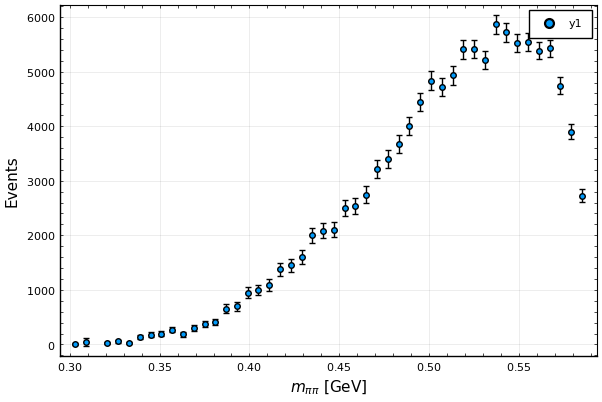

In [4]:
@plt_data data  xlab=L"m_{\pi\pi}"*" [GeV]"  ylab="Events"

In [5]:
const M = 3.686; const mπ = 0.14; const mJ = 3.097; 

λ(x, y, z) = x^2 + y^2 + z^2 - 2x*y - 2y*z - 2z*x

# a simple function that will be used to fit the data: QCD multipole expansion model for ψ'→J/ψπ⁺π⁻
# The important ππ FSI effect is not taken into account
# bg is just for introducing a third parameter
function dist(w, N, c, bg) 
    if (w ≤ 2mπ || w ≥ M-mJ)
        res = 0.0
    else
        q1 = sqrt(λ(w^2, mπ^2, mπ^2))/(2w)
        q2 = sqrt(λ(M^2, w^2, mJ^2))/(2M)
        res = N * q1 * q2 * (w^2 - c*mπ^2)^2 + bg
    end
    return res * 1e6
end;

dist(x, p) = dist(x, p...)

dist (generic function with 2 methods)

In [6]:
# parameters given individually
χsq1(N, c, bg) = chisq(dist, data, (N, c, bg));

# all parameters are vairables of χsq
fit1 = Minuit(χsq1, N = 1, c = 2, bg = 0, error_N = 0.1, error_c = 0.1, error_bg = 0.1)
fit1.strategy = 1;

In [7]:
# parameters are collected into a tuple or an array, which is the only variable of χsq
parname = [:N, :c, :bg]
χsq(par) = chisq(dist, data, par)
gradf(par) = gradient(χsq, par)
fit = Minuit(χsq, [1, 2, 0], error = 0.1*ones(3), name = parname, grad = gradf)
fit.strategy = 1;

# or simply using model_fit or @model_fit
fit2 = model_fit(dist, data, [1, 2, 0], error = 0.1*ones(3), name = parname, fix_bg = true)
fit2.strategy = 1;
migrad(fit2)

PyObject MigradResult(fmin=FMin(fval=68.21841491568557, edm=6.14734842872889e-05, tolerance=0.1, nfcn=60, ncalls=60, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='N', value=2.6681960437143837, error=0.04224516409271021, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='c', value=4.326170735305057, error=0.061681228609901384, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='bg', value=0.0, error=0.1, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [8]:
# the privous fit status can be passed to a new fit
fit2_new = model_fit(dist, data, fit2, name = parname, fix_bg = false)
migrad(fit2_new)

PyObject MigradResult(fmin=FMin(fval=64.67995814372355, edm=2.0802796267468135e-05, tolerance=0.1, nfcn=65, ncalls=65, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='N', value=2.611694784029727, error=0.051774157148768825, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='c', value=4.201402659318696, error=0.09309868134226096, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='bg', value=-2.187403330680718e-05, error=1.1893819057631849e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [8]:
@btime migrad(fit)
minos(fit)
migrad(fit)

  116.600 μs (1488 allocations: 40.48 KiB)


PyObject MigradResult(fmin=FMin(fval=64.67993733507895, edm=9.357751294516442e-15, tolerance=0.1, nfcn=3, ncalls=109923, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=2.6114833151653025, error=0.05177673323060879, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='x1', value=4.201031332818215, error=0.09311776395965805, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=-2.1921187450274414e-05, error=1.1895993246464892e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [9]:
@btime migrad(fit1)
minos(fit1)
migrad(fit1)

  73.600 μs (481 allocations: 9.27 KiB)


PyObject MigradResult(fmin=FMin(fval=64.679937335079, edm=1.5156345070287753e-14, tolerance=0.1, nfcn=14, ncalls=702922, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='N', value=2.6114833211935484, error=0.051776712195704004, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='c', value=4.201031344545451, error=0.09311685621270735, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='bg', value=-2.192118618207932e-05, error=1.1895620973146581e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [10]:
minos(fit1)

PyObject MErrors([('N', MError(name='N', is_valid=True, lower=-0.05145257573454067, upper=0.05210385773044046, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=56, min=2.6114833211935484)), ('c', MError(name='c', is_valid=True, lower=-0.09392066407552968, upper=0.09232893682255511, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=56, min=4.201031344545451)), ('bg', MError(name='bg', is_valid=True, lower=-1.2031491205034717e-05, upper=1.1765608570813917e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=56, min=-2.192118618207932e-05))])

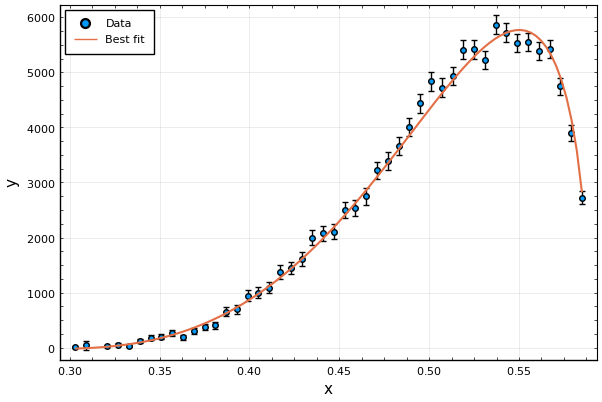

In [12]:
# the ordering of dist, fit and data does not matter
@plt_best dist fit data

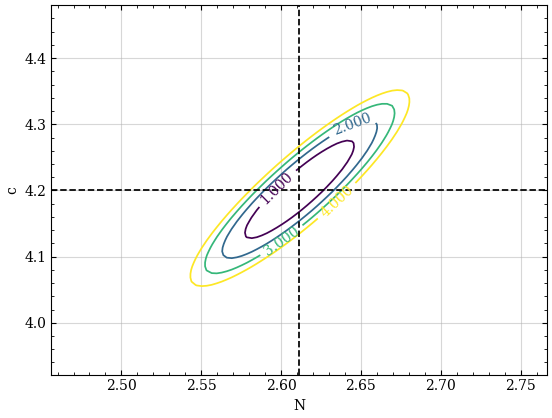

([2.4561531846064364, 2.4592911671637516, 2.4624291497210673, 2.4655671322783825, 2.4687051148356978, 2.4718430973930134, 2.4749810799503287, 2.4781190625076444, 2.4812570450649596, 2.484395027622275  …  2.738571614764822, 2.7417095973221373, 2.7448475798794525, 2.747985562436768, 2.7511235449940834, 2.7542615275513986, 2.7573995101087143, 2.7605374926660295, 2.7636754752233452, 2.7668134577806605], [3.9216807759073293, 3.9273242217384023, 3.932967667569476, 3.938611113400549, 3.944254559231622, 3.9498980050626953, 3.9555414508937683, 3.9611848967248418, 3.9668283425559148, 3.972471788386988  …  4.429590900703915, 4.435234346534989, 4.440877792366061, 4.446521238197135, 4.452164684028208, 4.457808129859281, 4.463451575690354, 4.469095021521428, 4.4747384673525, 4.480381913183574], [20.972585684547113 20.022934908552898 … 290.280110975979 296.3574252092246; 21.148382447267153 20.131613966475754 … 285.0424527312081 291.0755140159173; … ; 350.8725474805894 342.54598215294766 … 19.82633942

In [13]:
# MIGRAD contour of two parameters with the other ones fixed
# needs PyPlot or the pyplot backend of Plots
fit1.draw_contour(:N, :c, bound=3, bins=100)

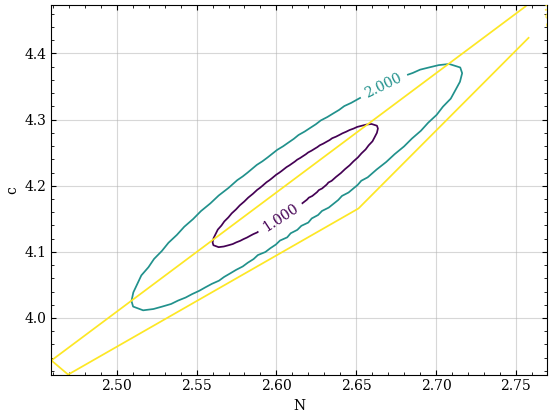

Error in MnContours : unable to find point on Contour : i+1 = 6
Error in MnContours : found  only i points : i = 5


PyObject <matplotlib.contour.ContourSet object at 0x7fd8c8793fd0>

In [14]:
# contour of parameter space from MINOS
fit1.draw_mncontour(:N, :c, nsigma=3, numpoints=100)

In [15]:
matrix(fit1, correlation = true)

PyObject ((1.0, 0.9252133738369328, 0.6055255848641659), (0.9252133738369328, 1.0, 0.7483973089680895), (0.6055255848641659, 0.7483973089680895, 1.0))

In [16]:
@show fit1.matrix
matrix(fit1)

fit1.matrix = ((0.0026808279257967637, 0.004460717050849894, 3.729529830296808e-7), (0.004460717050849894, 0.008670748910938015, 8.289868474538332e-7), (3.729529830296808e-7, 8.289868474538332e-7, 1.4150579833676482e-10))


PyObject ((0.0026808279257967637, 0.004460717050849894, 3.729529830296808e-07), (0.004460717050849894, 0.008670748910938015, 8.289868474538332e-07), (3.729529830296808e-07, 8.289868474538332e-07, 1.4150579833676482e-10))

In [18]:
# this gives parameter sets at the 1σ boundary
@time contour_df(fit1, χsq1, npts = 5)

  0.030399 seconds (56.06 k allocations: 1.447 MiB)


,chisq,N,c,bg
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.6799,2.56003,4.11414,-2.93031e-5
3,65.6799,2.66359,4.28643,-1.48855e-5
4,65.68,2.56385,4.10711,-3.10184e-5
5,65.6799,2.65961,4.29336,-1.32339e-5
6,65.68,2.5798,4.13027,-3.39527e-5
7,65.68,2.64221,4.2688,-1.01556e-5
8,65.68,2.56003,4.11439,-2.92436e-5
9,65.6799,2.5638,4.10711,-3.10202e-5


In [20]:
# random sampling of parameters in given ranges, keeping those within 1σ
@time parsam_df = contour_df_samples(fit1, χsq1, (:N, :c), ([2.5,2.8], [4.0,4.3]), nsamples = 3000)

  1.121674 seconds (2.72 M allocations: 87.125 MiB, 4.58% gc time)


,chisq,N,c,bg
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.5073,2.56962,4.11594,-3.03416e-5
3,64.9254,2.63565,4.23498,-1.96192e-5
4,65.6177,2.56222,4.12314,-2.8078e-5
5,64.8431,2.62984,4.23828,-1.82591e-5
6,65.6722,2.66245,4.27809,-1.61106e-5
7,65.1872,2.62854,4.20707,-2.32734e-5
8,65.1948,2.64385,4.26689,-1.54546e-5
9,64.9147,2.58663,4.15745,-2.57081e-5


In [21]:
# get parameter ranges
extrema(parsam_df.:N), extrema(parsam_df.:c)

((2.5616205401800602, 2.662654218072691), (4.111337112370791, 4.290896965655218))

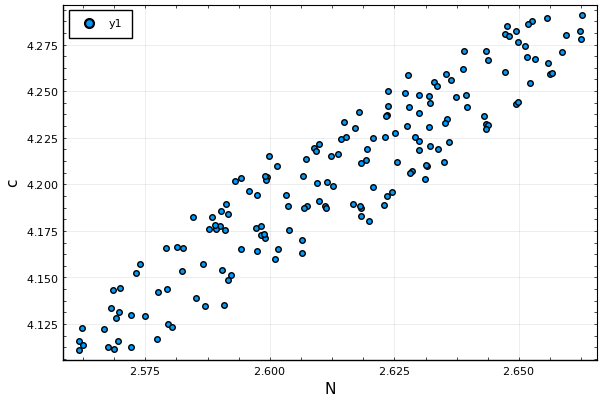

In [22]:
scatter(parsam_df.:N, parsam_df.:c, xlab = "N", ylab = "c")

In [24]:
@time contour_df_samples(fit, χsq, (:x0, :x1, :x2), ([2.5,2.8],  [4.0,4.3], (-3e-5,3e-5)), nsamples = 1000)

  0.256838 seconds (619.84 k allocations: 22.200 MiB)


,chisq,x0,x1,x2
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.1487,2.58529,4.15465,-2.26727e-5
3,65.3413,2.59429,4.18168,-1.76276e-5
4,64.9135,2.61471,4.19279,-2.58559e-5
5,65.4099,2.62823,4.23003,-2.52553e-5
6,64.8081,2.61441,4.21532,-1.82282e-5
7,64.9823,2.61652,4.1961,-2.05706e-5
8,64.9631,2.58769,4.16366,-2.67568e-5
9,65.6156,2.58318,4.17237,-2.71772e-5


In [26]:
@time contour_df_samples(fit, χsq, :x0, (2.5,2.8), nsamples = 20)

  0.056369 seconds (340.98 k allocations: 7.254 MiB)


,chisq,x0,x1,x2
,Float64,Float64,Float64,Float64
1,64.6799,2.61148,4.20103,-2.19212e-5
2,65.5614,2.56316,4.11968,-2.88302e-5
3,65.0779,2.57895,4.14646,-2.65198e-5
4,64.785,2.59474,4.17304,-2.42721e-5
5,64.6803,2.61053,4.19944,-2.20544e-5
6,64.7617,2.62632,4.2256,-1.98768e-5
7,65.0271,2.64211,4.2515,-1.77407e-5
8,65.4744,2.65789,4.27721,-1.56345e-5


## Example A in the iminuit tutorial

The example is [Example A: Fit of a gaussian model to a histogram](https://nbviewer.jupyter.org/github/scikit-hep/iminuit/blob/master/tutorial/automatic_differentiation.ipynb)

In [ ]:
Pkg.add("SpecialFunctions")

In [58]:
using PyCall

In [59]:
# import numpy from Python to generate the same data as in the example
np = pyimport(:numpy)
default_rng = pyimport("numpy.random").default_rng
rng = default_rng(seed=1)
const w, xe = np.histogram(rng.normal(0, 1, 10000), bins=1000)

([1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [-3.8378621427178974, -3.830092502694802, -3.8223228626717063, -3.8145532226486107, -3.806783582625515, -3.7990139426024196, -3.791244302579324, -3.7834746625562286, -3.775705022533133, -3.7679353825100375  …  3.8618511201697956, 3.869620760192891, 3.8773904002159867, 3.8851600402390822, 3.892929680262178, 3.9006993202852733, 3.908468960308369, 3.9162386003314644, 3.92400824035456, 3.931777880377655])

In [60]:
# define the model and the score function to minimize
using SpecialFunctions

function cdf(x, par)
    mu, sigma = par
    z = (x - mu) / sigma
    return 0.5 * (1 + erf(z / sqrt(2))) 
end

function score(par)
    amp = par[1]
    rest = par[2:end]
    mu = amp * (cdf.(xe[2:end], Ref(rest)) - cdf.(xe[1:end-1], Ref(rest)) )
    return 2 * sum(@. mu - w * log(mu + 1e-100))
end

score (generic function with 1 method)

In [61]:
const start_values = [1.5 * sum(w), 1.0, 2.0]
const limits = [(0, nothing), nothing, (0, nothing)];

In [62]:
# w/o grad
m = Minuit(score, start_values, limit=limits)
m.strategy = 0

# using grad
grad_fd(pars) =  gradient(score, pars)
m_fd = Minuit(score, start_values, limit=limits, grad = grad_fd)
m_fd.strategy = 0;

In [63]:
@btime migrad(m)

  627.100 μs (475 allocations: 460.64 KiB)


PyObject MigradResult(fmin=FMin(fval=-38710.19985212475, edm=2.0142820069460498e-12, tolerance=0.1, nfcn=8, ncalls=39692, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=10001.040137685515, error=99.56265139939478, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None), Param(number=1, name='x1', value=-0.01105171350465089, error=0.010013546547205668, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=0.9992897105689829, error=0.007141203766656945, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None)])

In [64]:
@btime migrad(m_fd)

  380.300 μs (257 allocations: 348.22 KiB)


PyObject MigradResult(fmin=FMin(fval=-38710.19985212736, edm=9.414200054796711e-12, tolerance=0.1, nfcn=3, ncalls=27164, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='x0', value=10001.039987391317, error=99.95742260033421, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None), Param(number=1, name='x1', value=-0.011051729329187911, error=0.009992544958620243, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='x2', value=0.9992893655857928, error=0.00710107169380747, is_const=False, is_fixed=False, has_limits=True, has_lower_limit=True, has_upper_limit=False, lower_limit=0.0, upper_limit=None)])